In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#William Connor Parham
#Dr. Hairong Qi
#COSC 522
#Project 1
#9/19/2023

**Read In Training and Testing Set**


Text(0.5, 1.0, 'Positive and Negative Synthetic training Data')

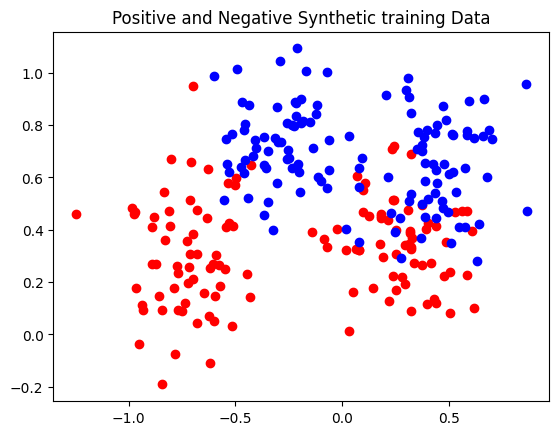

In [53]:
#Read in our training and testing files
training_set = np.loadtxt("synth.tr",skiprows=1)
testing_set = np.loadtxt("synth.te", skiprows=1)

#Instantiate arrays to graph our training data
training_set_x_c1, training_set_y_c1 = [], []
training_set_x_c2, training_set_y_c2 = [], []
testing_set_x_c1, testing_set_y_c1 = [], []
testing_set_x_c2, testing_set_y_c2 = [], []

#sort our training data by class.
for item in training_set:
    if(item[2] == 0):
        training_set_x_c1.append(item[0])
        training_set_y_c1.append(item[1])
    else:
        training_set_x_c2.append(item[0])
        training_set_y_c2.append(item[1])

#Plot our data
plt.scatter(training_set_x_c1, training_set_y_c1,c='red')
plt.scatter(training_set_x_c2, training_set_y_c2, c='blue')
plt.title('Positive and Negative Synthetic training Data')

**Minimum Euclidean Distance Classifier**

In [54]:
class MED_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value

    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        class_0_data, class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                class_0_data.append(item)
            else:
                class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        c0_cov = np.cov(class_0_centered,rowvar=False)
        c1_cov = np.cov(class_1_centered, rowvar=False)

        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 2):
            variance += c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 2):
            variance += c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas

    #We will make predictions about our testing_set here.  This is what will "classify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [] #variable to hold the actual class of the testing set
        self.probs = [] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        #print('blorbus: ', self.testing_set_class_0[0][:2])
        for i in range(0, len(testing_set)):
            self.actual_class.append(testing_set[i][2])
            c0 = (np.dot(np.transpose(self.means[0]) / self.sigmas[0], testing_set[i, :2]) - np.dot(np.transpose(self.means[0]), self.means[0]) / (2 * self.sigmas[0]) + np.log(self.prior))
            c1 = (np.dot(np.transpose(self.means[1]) / self.sigmas[1], testing_set[i, :2]) - np.dot(np.transpose(self.means[1]), self.means[1]) / (2 * self.sigmas[1]) + np.log(self.prior))

            self.probs.append((c0,c1))

    #We will evaluate our model here    
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        for i in range(0, len(self.probs)):
            if(self.probs[i][0] > self.probs[i][1]):
                chosen_class = 0
            else:
                chosen_class = 1
                
            if(chosen_class == self.actual_class[i]):
                accuracy_counter += 1
        
        print('Accuracy: ', 100 * (accuracy_counter / (len(self.probs))))

med_classifier = MED_Classifier()
med_classifier.fit(training_set=training_set)
med_classifier.predict(testing_set=testing_set)
med_classifier.evaluate()

Accuracy:  82.6


**Minimum Mahalanobis Distance Classifier**

In [55]:
class MMD_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value

    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        class_0_data, class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                class_0_data.append(item)
            else:
                class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        self.c0_cov = np.cov(class_0_centered,rowvar=False)
        self.c1_cov = np.cov(class_1_centered, rowvar=False)

        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 2):
            variance += self.c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 2):
            variance += self.c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas

    #We will make predictions about our testing_set here.  This is what will "classify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [] #variable to hold the actual class of the testing set
        self.probs = [] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        #print('blorbus: ', self.testing_set_class_0[0][:2])
        for i in range(0, len(testing_set)):
            self.actual_class.append(testing_set[i][2])
            
            c0 = np.linalg.multi_dot([np.transpose(self.means[0]), np.transpose(np.linalg.inv(self.c0_cov)), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), self.means[0]]) + np.log(self.prior)
            c1 = np.linalg.multi_dot([np.transpose(self.means[1]), np.transpose(np.linalg.inv(self.c1_cov)), testing_set[i][:2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), self.means[1]]) + np.log(self.prior)

            self.probs.append((c0,c1))

    #We will evaluate our model here    
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        for i in range(0, len(self.probs)):
            if(self.probs[i][0] > self.probs[i][1]):
                chosen_class = 0
            else:
                chosen_class = 1
                
            if(chosen_class == self.actual_class[i]):
                accuracy_counter += 1
        
        print('Accuracy: ', 100 * (accuracy_counter / (len(self.probs))))


mmd_classifier = MMD_Classifier()
mmd_classifier.fit(training_set=training_set)
mmd_classifier.predict(testing_set=testing_set)
mmd_classifier.evaluate()

Accuracy:  87.1


**Maximum Posterior Probability Classifier**


In [56]:
class MPP_Classifier():
    
    def _innit_(self):
        self.X_train = [] #x_train data
        self.y_train = [] #y_train data
        self.classes = [] #list of classes
        self.means = [] #list to hold class means used in predict.
        self.sigmas = None #list to hold each sigma value

    #We will fit our training_set to the classifier here.  This is what "trains" our model to be able to predict things.
    def fit(self,training_set):
        #The first thing we need to do is sepperate our training set into lists based on class.
        #We can do this by concatting every class in our training set then calling np.unique to get all unique values.
        self.classes = np.unique(training_set[:,2])
        class_means = [] #list to hold all class means
        class_0_data, class_1_data = [], [] #list to hold all points of class 0 and 1 data
        class_0_data_nc, class_1_data_nc = [], [] #list to hold all points of class 0 and 1 data without the class variable
        class_0_centered, class_1_centered = [], [] #list to hold centered data after subtracting mean
        c0_cov = [] #list to hold the covariance matrix for class 0
        c1_cov = [] #list to hold the covariance matrix for class 1
        sigmas = [] #list to gold the sigma values for each class

        for item in training_set:
            if(item[2] == 0):
                class_0_data.append(item)
            else:
                class_1_data.append(item)

        #Here I am stripping the class column off each array
        temp = []
        for subarray in class_0_data:
            temp.append(subarray[:2])
        class_0_data_nc = temp
        temp = []
        for subarray in class_1_data:
            temp.append(subarray[:2])
        class_1_data_nc = temp

        #Calculate the mean of each class's data cluster
        class_means.append(np.mean(class_0_data_nc, axis=0))
        class_means.append(np.mean(class_1_data_nc, axis=0))
        
        self.means = class_means

        #center our data by subtracting the mean from each point
        class_0_centered = class_0_data_nc - class_means[0]
        class_1_centered = class_1_data_nc - class_means[1]

        #calculate the covariance of each class
        self.c0_cov = np.cov(class_0_centered,rowvar=False)
        self.c1_cov = np.cov(class_1_centered, rowvar=False)

        ##I have no idea if this is correct.  This is worth checking with a ta or Dr. Qi.
        #Find the variance / sigma of both class 1 and class 2
        variance = 0
        for i in range(0, 2):
            variance += self.c0_cov[i][i]
        sigmas.append(variance/2)

        variance = 0
        for i in range(0, 2):
            variance += self.c1_cov[i][i]
        sigmas.append(variance/2)
        self.sigmas = sigmas

    #We will make predictions about our testing_set here.  This is what will "classify the data for us".
    def predict(self,testing_set):
        #for each testing point we want to find the minimum euclidean distance to the mean of the data.
        self.actual_class = [] #variable to hold the actual class of the testing set
        self.probs = [] #variable to hold probabilities for each class, probs[0] = class 0 & probs[1] = class 1
        self.testing_set_class_0 = testing_set[testing_set[:, -1] == 0][:, :3]  # Data points in class 0
        self.testing_set_class_1 = testing_set[testing_set[:, -1] == 1][:, :3]  # Data points in class 1
        self.prior = 0.5 #prior knowledge constant

        #print('blorbus: ', self.testing_set_class_0[0][:2])
        for i in range(0, len(testing_set)):
            self.actual_class.append(testing_set[i][2])
            
            c0 = (-0.5) * np.linalg.multi_dot([(np.transpose(testing_set[i, :2])), np.linalg.inv(self.c0_cov), testing_set[i, :2]]) + np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[0]), np.linalg.inv(self.c0_cov), self.means[0]]) + (-0.5) * np.log(np.linalg.det(self.c0_cov))
            c1 = (-0.5) * np.linalg.multi_dot([(np.transpose(testing_set[i, :2])), np.linalg.inv(self.c1_cov), testing_set[i, :2]]) + np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), testing_set[i, :2]]) + (-0.5) * np.linalg.multi_dot([np.transpose(self.means[1]), np.linalg.inv(self.c1_cov), self.means[1]]) + (-0.5) * np.log(np.linalg.det(self.c1_cov))

            self.probs.append((c0,c1))

    #We will evaluate our model here    
    def evaluate(self):
        #loop through each probability and determine whether class 0 or class 1 is higher.
        #compare the chosen probability to the actual probability inside self.actual_class.
        #if correct add +1 to accuracy counter.
        #divide correct scores by total scores to find percent classified correctly.

        chosen_class = None
        accuracy_counter = 0
        for i in range(0, len(self.probs)):
            if(self.probs[i][0] > self.probs[i][1]):
                chosen_class = 0
            else:
                chosen_class = 1
                
            if(chosen_class == self.actual_class[i]):
                accuracy_counter += 1
        
        print('Accuracy: ', 100 * (accuracy_counter / (len(self.probs))))


mpp_classifier = MPP_Classifier()
mpp_classifier.fit(training_set=training_set)
mpp_classifier.predict(testing_set=testing_set)
mpp_classifier.evaluate()

Accuracy:  89.8


**K-Nearest Neighbor Implementation**

In [72]:
k_vals = []
accuracies = []

In [77]:
class KNN_classifier():
    def __init__(self, k_nearest):
        self.k_nearest = k_nearest
        self.sorted_lists = []

    def predict(self, training_set, testing_point):
        distances = []
        for j in range(0, len(training_set)):
            distance = np.linalg.norm(training_set[j][:2] - testing_point[:2])
            distances.append((distance, training_set[j][2]))     
        
        distances = np.array(distances)
        sorted = distances[np.argsort(distances[:,0])]
        self.sorted_lists.append(sorted)

    def fit(self, training_set, testing_set):
        for i in range(0, len(testing_set)):
            self.predict(training_set, testing_set[i])

    def evaluate(self, testing_set):
        accuracy_count = 0
        for i in range(0, len(testing_set)):
            actual_class = testing_set[i][2]
            predicted_class = None
            class_0_count, class_1_count = 0, 0
            for j in range(0, self.k_nearest):
                if self.sorted_lists[i][j][1] == 0:
                    class_0_count += 1
                else:
                    class_1_count += 1
            
            if class_0_count > class_1_count:
                predicted_class = 0
            elif class_0_count < class_1_count:
                predicted_class = 1
            else:
                predicted_class = np.random.normal(0,1,1)
            
            if(actual_class == predicted_class):
                accuracy_count += 1
        
        acc_percent = 100 * accuracy_count / len(testing_set)
        return acc_percent

knn_classifier = KNN_classifier(k_nearest=31)
knn_classifier.fit(training_set, testing_set)
knn_classifier.evaluate(testing_set)

val_accs = []

for i in range(1, 251, 2):
    knn_classifier = KNN_classifier(k_nearest=i)
    knn_classifier.fit(training_set, testing_set)

    k_vals.append(i)
    acc = knn_classifier.evaluate(testing_set)
    accuracies.append(acc)

    val_accs.append((acc, i))

val_accs = np.array(val_accs)
sorted_val_accs = val_accs[np.argsort(val_accs[:,0])]

print(sorted_val_accs)


1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199
201
203
205
207
209
211
213
215
217
219
221
223
225
227
229
231
233
235
237
239
241
243
245
247
249
[[ 57.5 249. ]
 [ 58.9 247. ]
 [ 61.7 241. ]
 [ 61.8 237. ]
 [ 61.9 245. ]
 [ 62.1 239. ]
 [ 62.3 233. ]
 [ 62.4 235. ]
 [ 62.6 243. ]
 [ 62.8 231. ]
 [ 62.9 227. ]
 [ 63.1 225. ]
 [ 63.3 229. ]
 [ 63.4 223. ]
 [ 63.5 221. ]
 [ 63.6 219. ]
 [ 63.6 203. ]
 [ 63.6 205. ]
 [ 63.7 217. ]
 [ 63.7 201. ]
 [ 63.8 199. ]
 [ 63.8 215. ]
 [ 63.8 209. ]
 [ 63.9 211. ]
 [ 63.9 195. ]
 [ 63.9 193. ]
 [ 63.9 207. ]
 [ 64.  213. ]
 [ 64.  197. ]
 [ 64.2 181. ]
 [ 64.2 179. ]
 [ 64.3 177. ]
 [ 64.3 185. ]
 [ 64.3 187. ]
 [ 64.3 189. ]
 [ 64.3 191. ]
 [ 64.4 183. ]


Text(0, 0.5, 'Accuracies')

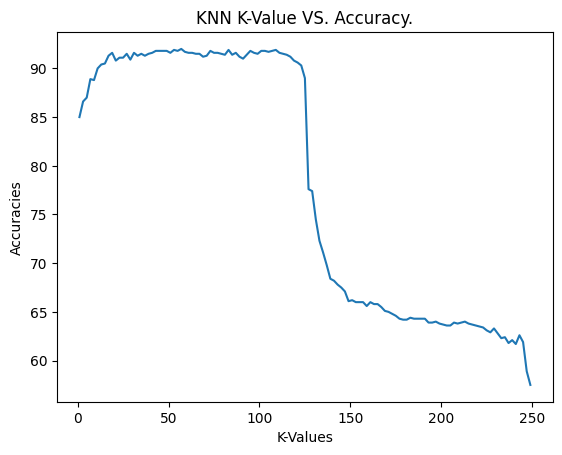

In [74]:
plt.plot(k_vals, accuracies)
plt.title('KNN K-Value VS. Accuracy.')
plt.xlabel('K-Values')
plt.ylabel('Accuracies')